# Variational Quantum Classifier for Binary Classification

**Authors:** Koło Naukowe Axion  
**Dataset:** Banknote Authentication (UCI ML Repository)  
**Framework:** Qiskit Machine Learning + PyTorch

## Abstract

This notebook demonstrates a hybrid Variational Quantum Circuit (VQC) for binary classification using the banknote authentication dataset. The model leverages:

- **Feature encoding**: Angle encoding via RY rotations
- **Parametrized quantum circuit (VQC)**: Hardware-efficient ansatz with ring topology entanglement
- **Measurement**: Expectation value of the Pauli-Z observable on the first qubit
- **Classical optimizer**: Adam optimizer via PyTorch's automatic differentiation

The hybrid architecture uses Qiskit's `EstimatorQNN` bridged to PyTorch via `TorchConnector`, enabling seamless gradient-based training on a simulated quantum computer.

## 1. Environment Setup

This section handles dependency installation and imports. For reproducibility, all package versions should be pinned in a production environment.

### 1.1 Package Installation (Optional)

Set `INSTALL_DEPS = True` if running in a fresh environment. For production use, pin specific versions.

In [ ]:
# Optional: Install dependencies if not already present
INSTALL_DEPS = False

if INSTALL_DEPS:
    import sys
    import subprocess
    
    packages = [
        'numpy',
        'scikit-learn',
        'ucimlrepo',
        'qiskit',
        'qiskit-machine-learning',
        'torch',
        'matplotlib'
    ]
    
    for pkg in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])

### 1.2 Imports

In [ ]:
# Standard library
import random

# Third-party: Scientific computing
import numpy as np
import matplotlib.pyplot as plt

# Third-party: Machine learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from ucimlrepo import fetch_ucirepo

# Third-party: Quantum computing
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN


## 2. Reproducibility and Random Seed Control

In [ ]:
def set_random_seed(seed: int = 42) -> None:
    """
    Set random seeds for reproducibility across numpy, PyTorch, and Python's random module.
    
    Parameters
    ----------
    seed : int
        Random seed value (default: 42)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set global seed
RANDOM_SEED = 42
set_random_seed(RANDOM_SEED)

## 3. Data Preparation

The **Banknote Authentication Dataset** contains features extracted from images of genuine and forged banknotes. We perform feature engineering (interaction term) and scale features to the range [0, π] for angle encoding.

In [ ]:
def prepare_data(test_size: float = 0.2, random_state: int = 42):
    """
    Fetch and preprocess the Banknote Authentication dataset.
    
    The dataset contains 4 original features extracted from wavelet-transformed images:
    - Variance of image
    - Skewness of image  
    - Curtosis of image
    - Entropy of image
    
    We engineer one additional interaction feature (variance × skewness) and scale
    all features to [0, π] for angle encoding in the quantum circuit.
    
    Parameters
    ----------
    test_size : float
        Fraction of data to reserve for testing (default: 0.2)
    random_state : int
        Random seed for train/test split (default: 42)
    
    Returns
    -------
    X_train : np.ndarray
        Training features, shape (n_train, 5), scaled to [0, π]
    X_test : np.ndarray
        Test features, shape (n_test, 5), scaled to [0, π]
    y_train : np.ndarray
        Training labels, shape (n_train,), values in {0, 1}
    y_test : np.ndarray
        Test labels, shape (n_test,), values in {0, 1}
        
    Notes
    -----
    - Dataset ID 267 from UCI ML Repository
    - Original features: 4, engineered features: 1, total: 5
    - Scaling range [0, π] is required for RY angle encoding gates
    """
    # Fetch dataset from UCI repository
    banknote_authentication = fetch_ucirepo(id=267)
    X = banknote_authentication.data.features.to_numpy()
    y = banknote_authentication.data.targets.to_numpy().ravel()
    
    # Sanity checks
    assert X.shape[1] == 4, f"Expected 4 features, got {X.shape[1]}"
    assert set(np.unique(y)) == {0, 1}, f"Expected binary labels {{0, 1}}, got {set(np.unique(y))}"
    
    # Feature engineering: interaction term
    variance = X[:, 0].reshape(-1, 1)
    skewness = X[:, 1].reshape(-1, 1)
    interaction = variance * skewness
    X_expanded = np.hstack((X, interaction))
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_expanded, y, test_size=test_size, random_state=random_state
    )
    
    # Scale features to [0, π] for angle encoding
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Dataset loaded: {len(X_train)} train, {len(X_test)} test samples")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")
    print(f"Class distribution (train): {np.bincount(y_train.astype(int))}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test

## 4. Quantum Circuit Architecture

The quantum model consists of two components:
1. **Feature map** (angle encoding): Encodes classical data into quantum states
2. **Ansatz** (trainable circuit): Parametrized quantum circuit with learnable weights

### 4.1 Parametrized Ansatz

Ansatz with alternating rotation and entanglement layers. The circuit uses a ring topology for entanglement, alternating between forward (CRX) and reverse (CRY) connections.

In [ ]:
def ansatz(n_qubits, depth):
    """
    Construct a hardware-efficient ansatz with alternating rotation and entanglement layers.
    
    Architecture
    ------------
    The ansatz consists of (depth // 2) macro-layers, where each macro-layer contains:
    - **Layer 1**: RY rotations + CRX entanglement (forward ring: i → i+1)
    - **Layer 2**: RX rotations + CRY entanglement (reverse ring: i → i-1)
    
    Parameters
    ----------
    n_qubits : int
        Number of qubits in the circuit
    depth : int
        Number of layers (must be even). Total macro-layers = depth // 2
    
    Returns
    -------
    QuantumCircuit
        Parametrized quantum circuit with learnable parameters θ
    
    Notes
    -----
    - Total trainable parameters: 2 × n_qubits × depth
    - Each macro-layer has 4 × n_qubits parameters:
        * n_qubits for RY rotations
        * n_qubits for CRX entanglement angles
        * n_qubits for RX rotations
        * n_qubits for CRY entanglement angles
    - Ring topology ensures all-to-all connectivity with minimal gate depth
    - Constraint: depth must be even (enforced by loop structure)
    """

    # Create a vector of learnable parameters.
    # Total parameters = 2 * num_qubits * depth (2 * n_qubits per full loop iteration).
    theta = ParameterVector('θ', 2 * n_qubits * depth)
    qc = QuantumCircuit(n_qubits)
    
    param_idx = 0
    
    # The loop iterates (depth // 2) times.
    for j in range(depth // 2):

        # -------- Layer 1 --------
        
        # Sub-layer: Independent RY rotations
        for i in range(n_qubits):
            qc.ry(theta[param_idx], i)
            param_idx += 1

        # Sub-layer: Entanglement (CRX) - Ring Topology
        # Connects i -> i+1 (wrapping around to 0 at the end)
        for i in range(n_qubits):
            control = i
            target = (i + 1) % n_qubits
            qc.crx(theta[param_idx], control, target)
            param_idx += 1


        # -------- Layer 2 --------
        
        # Sub-layer: Independent RX rotations
        for i in range(n_qubits):
            qc.rx(theta[param_idx], i)
            param_idx += 1

        # Sub-layer: Entanglement (CRY) - Reverse Ring Topology
        # Connects i -> i-1 (wrapping around to N-1)
        for i in range(n_qubits):
            control = i
            target = (i - 1) % n_qubits
            qc.cry(theta[param_idx], control, target)
            param_idx += 1

    return qc

### 4.2 Hybrid Variational Quantum Circuit

The `HybridModel` class implements a VQC by integrating the quantum circuit with PyTorch's autograd system via Qiskit's `TorchConnector`. This enables gradient-based optimization of quantum parameters using classical optimizers.

In [ ]:
class HybridModel(nn.Module):
    """
    Hybrid Variational Quantum Circuit (VQC) for binary classification.
    
    The model combines:
    1. Angle encoding feature map (classical data → quantum state)
    2. Parametrized ansatz (trainable quantum circuit)
    3. Observable measurement (quantum state → classical expectation value)
    4. PyTorch integration via TorchConnector (enables backpropagation)
    
    Parameters
    ----------
    ansatz_circuit : QuantumCircuit
        Parametrized quantum circuit with trainable weights
    num_qubits : int
        Number of qubits (must match feature dimension)
    
    Attributes
    ----------
    qnn : EstimatorQNN
        Qiskit's EstimatorQNN that computes expectation values
    quantum_layer : TorchConnector
        PyTorch-compatible wrapper enabling gradient computation
    
    Notes
    -----
    - **Feature encoding**: RY(x_i) on qubit i encodes feature x_i
    - **Observable**: Pauli-Z on qubit 0, measuring spin in computational basis
    - **Output range**: [-1, +1] (expectation value of Z operator)
    - **Gradient method**: Parameter shift rule for quantum gradients
    - **Simulator**: StatevectorEstimator (change for real quantum hardware)
    """
    
    def __init__(self, ansatz_circuit, num_qubits):
        super().__init__()
        
        # Create angle encoding feature map
        self.feature_map = self._create_angle_encoding(num_qubits)
        
        # Compose full quantum circuit: feature_map → ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map, qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)
        
        # Separate input parameters (from feature map) and weight parameters (from ansatz)
        # This distinction is crucial for EstimatorQNN to correctly handle data vs. trainable weights
        input_params = list(self.feature_map.parameters)
        weight_params = list(ansatz_circuit.parameters)
        
        # Define observable: measure Z on qubit 0 (identity on other qubits)
        # Pauli string ordering: rightmost character = qubit 0
        # Example for 5 qubits: "IIIIZ" measures Z on q0, I on q1-q4
        observable = SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)])
        
        # Initialize statevector simulator for noiseless quantum simulation
        # NOTE: Replace with Sampler or real backend for quantum hardware deployment
        estimator = StatevectorEstimator()
        
        # Use parameter shift rule for computing quantum gradients
        # This is exact (not finite-difference) and works on hardware
        gradient = ParamShiftEstimatorGradient(estimator)
        
        # Create variational quantum circuit using EstimatorQNN
        # EstimatorQNN computes <ψ|O|ψ> where |ψ> = ansatz(weights)|feature_map(x)>
        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=input_params,
            weight_params=weight_params,
            estimator=estimator,
            gradient=gradient
        )
        
        # Wrap the VQC as a PyTorch module
        # TorchConnector bridges Qiskit and PyTorch autograd systems,
        # allowing standard PyTorch optimizers (SGD, Adam, etc.) to train quantum parameters
        self.quantum_layer = TorchConnector(self.qnn)
    
    def _create_angle_encoding(self, num_qubits: int) -> QuantumCircuit:
        """
        Create angle encoding feature map: |0⟩ → RY(x₀) ⊗ RY(x₁) ⊗ ... ⊗ RY(xₙ) |0⟩
        
        Each classical feature x_i ∈ [0, π] is encoded as a rotation angle on qubit i.
        This maps the feature vector to the amplitude of the quantum state.
        
        Parameters
        ----------
        num_qubits : int
            Number of qubits (and features)
        
        Returns
        -------
        QuantumCircuit
            Feature map circuit with n_qubits input parameters
        """
        qc_data = QuantumCircuit(num_qubits)
        input_params = ParameterVector('x', num_qubits)
        for i in range(num_qubits):
            qc_data.ry(input_params[i], i)
        return qc_data
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the hybrid variational quantum circuit.
        
        Parameters
        ----------
        x : torch.Tensor
            Input features, shape (batch_size, num_qubits)
        
        Returns
        -------
        torch.Tensor
            Expectation values, shape (batch_size, 1), range [-1, +1]
        """
        return self.quantum_layer(x)

## 5. Training Configuration and Data Loading

In [ ]:
# Hyperparameters
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 0.01
NUM_QUBITS = 5
ANSATZ_DEPTH = 6

# Load and prepare data
X_train, X_test, y_train_raw, y_test_raw = prepare_data(
    test_size=0.2, 
    random_state=RANDOM_SEED
)

# Map labels from {0, 1} to {-1, +1} to match Z observable range
y_train = 2 * y_train_raw - 1
y_test = 2 * y_test_raw - 1

# Convert to float32 for PyTorch compatibility
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

Loading data...
Data ready. Number of training samples: 1097


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Create DataLoader for batched training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

## 6. Model Training

We train the hybrid VQC using Mean Squared Error (MSE) loss and the Adam optimizer. The training loop evaluates both training and test performance at each epoch.

In [ ]:
def train_epoch(model, train_loader, optimizer, loss_fn):
    """
    Train the VQC model for one epoch.
    
    Parameters
    ----------
    model : nn.Module
        Hybrid variational quantum circuit model
    train_loader : DataLoader
        Training data loader
    optimizer : torch.optim.Optimizer
        Optimizer for updating model parameters
    loss_fn : nn.Module
        Loss function (e.g., MSELoss)
    
    Returns
    -------
    float
        Average training loss over all batches
    """
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    return epoch_loss / num_batches


def evaluate(model, X_tensor, y_tensor, loss_fn):
    """
    Evaluate the VQC model on a dataset.
    
    Parameters
    ----------
    model : nn.Module
        Hybrid variational quantum circuit model
    X_tensor : torch.Tensor
        Input features
    y_tensor : torch.Tensor
        True labels (in {-1, +1})
    loss_fn : nn.Module
        Loss function
    
    Returns
    -------
    dict
        Dictionary containing 'loss' and 'accuracy'
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = loss_fn(outputs, y_tensor).item()
        
        # Convert continuous outputs to binary predictions
        # outputs > 0 → class +1, outputs ≤ 0 → class -1
        predicted = (outputs > 0).float() * 2 - 1
        correct = (predicted == y_tensor).sum().item()
        accuracy = correct / len(y_tensor)
    
    return {'loss': loss, 'accuracy': accuracy}


# Initialize model, loss, and optimizer
final_ansatz = ansatz(NUM_QUBITS, ANSATZ_DEPTH)
model = HybridModel(final_ansatz, NUM_QUBITS)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
train_loss_history = []
test_loss_history = []
test_acc_history = []

print(f"Starting training for {EPOCHS} epochs...")
print(f"Model: {NUM_QUBITS} qubits, ansatz depth {ANSATZ_DEPTH}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print("-" * 60)

for epoch in range(EPOCHS):
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, loss_function)
    
    # Evaluate on test set
    test_metrics = evaluate(model, X_test_tensor, y_test_tensor, loss_function)
    
    # Log metrics
    train_loss_history.append(train_loss)
    test_loss_history.append(test_metrics['loss'])
    test_acc_history.append(test_metrics['accuracy'])
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Test Loss: {test_metrics['loss']:.4f} | "
              f"Test Acc: {test_metrics['accuracy']:.4f}")

print("-" * 60)
print("Training complete!")

Starting training... Epochs: 30
Epoch 1/30 | Avg loss: 0.5392 | Test Acc: 0.8691
Epoch 2/30 | Avg loss: 0.3907 | Test Acc: 0.8727
Epoch 3/30 | Avg loss: 0.3748 | Test Acc: 0.8727
Epoch 4/30 | Avg loss: 0.3674 | Test Acc: 0.9236
Epoch 5/30 | Avg loss: 0.3609 | Test Acc: 0.9055
Epoch 6/30 | Avg loss: 0.3645 | Test Acc: 0.9236
Epoch 7/30 | Avg loss: 0.3544 | Test Acc: 0.9164
Epoch 8/30 | Avg loss: 0.3566 | Test Acc: 0.9382
Epoch 9/30 | Avg loss: 0.3577 | Test Acc: 0.8618
Epoch 10/30 | Avg loss: 0.3504 | Test Acc: 0.8873
Epoch 11/30 | Avg loss: 0.3567 | Test Acc: 0.9273
Epoch 12/30 | Avg loss: 0.3556 | Test Acc: 0.8982
Epoch 13/30 | Avg loss: 0.3529 | Test Acc: 0.9273
Epoch 14/30 | Avg loss: 0.3537 | Test Acc: 0.9273
Epoch 15/30 | Avg loss: 0.3518 | Test Acc: 0.9309
Epoch 16/30 | Avg loss: 0.3494 | Test Acc: 0.9236
Epoch 17/30 | Avg loss: 0.3505 | Test Acc: 0.9273
Epoch 18/30 | Avg loss: 0.3479 | Test Acc: 0.9309
Epoch 19/30 | Avg loss: 0.3498 | Test Acc: 0.9236
Epoch 20/30 | Avg loss: 0.3

## 7. Evaluation and Visualization

We evaluate the trained model using standard classification metrics and visualize the learning curves and confusion matrix.

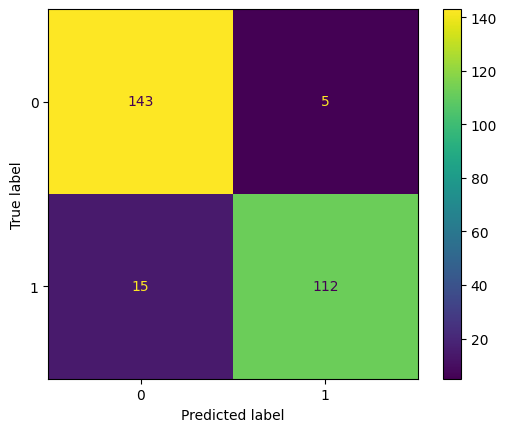

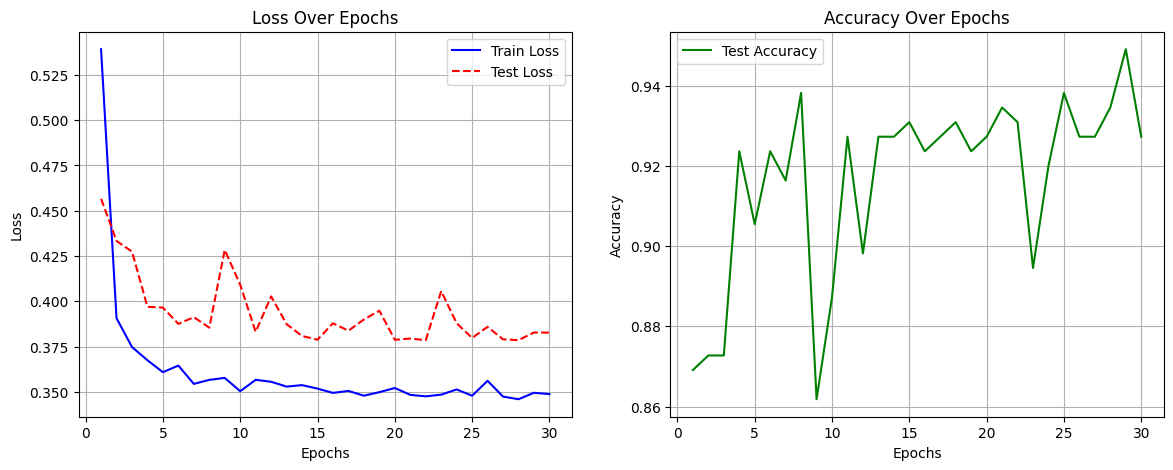

F1 SCORE:  0.9180327868852459  | ACCURACY SCORE:  0.9272727272727272


In [ ]:
# Generate predictions on test set
with torch.no_grad():
    test_outputs = model(X_test_tensor).numpy()

# Convert to binary predictions: output > 0 → +1, else → -1
y_pred = np.where(test_outputs > 0, 1, -1).flatten()

# Compute metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, pos_label=1)

print(f"\nFinal Test Performance:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1 Score: {test_f1:.4f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training and test loss
epochs_range = range(1, len(train_loss_history) + 1)
axes[0].plot(epochs_range, train_loss_history, label='Train Loss', color='#1f77b4', linewidth=2)
axes[0].plot(epochs_range, test_loss_history, label='Test Loss', color='#ff7f0e', linewidth=2, linestyle='--')
axes[0].set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Test accuracy
axes[1].plot(epochs_range, test_acc_history, label='Test Accuracy', color='#2ca02c', linewidth=2)
axes[1].set_title('Test Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_ylim([0, 1.05])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Plot 3: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class -1', 'Class +1'])
cm_display.plot(ax=axes[2], cmap='Blues', values_format='d')
axes[2].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Summary and Reproducibility Notes

### Reproducibility

This notebook is designed for reproducibility:
- **Random seed**: Fixed at `RANDOM_SEED = 42` for numpy, PyTorch, and Python's random module
- **Data split**: Deterministic train/test split with `random_state=42`
- **Feature scaling**: MinMaxScaler fit only on training data, then applied to test data
- **Batch shuffling**: DataLoader uses PyTorch's random generator (seeded)

### VQC Architecture Summary

- **Qubits**: 5 (matching the 5 engineered features)
- **Ansatz depth**: 6 layers (3 macro-layers)
- **Trainable parameters**: 60 quantum parameters (2 × 5 × 6)
- **Feature encoding**: Angle encoding via RY gates
- **Observable**: Pauli-Z expectation on qubit 0
- **Optimizer**: Adam with learning rate 0.01
- **Loss function**: Mean Squared Error (MSE)

### Limitations and Future Work

1. **Simulator only**: Uses `StatevectorEstimator` for noiseless simulation. Real quantum hardware would require:
   - Replacing with a real backend (e.g., IBM Quantum)
   - Adding error mitigation strategies
   - Adjusting circuit depth for hardware constraints

2. **Feature engineering**: The interaction term (variance × skewness) was manually engineered. Automated feature selection could improve performance.

3. **Hyperparameter tuning**: Current hyperparameters (learning rate, batch size, ansatz depth) were not systematically optimized.

4. **Single-qubit measurement**: Only measuring qubit 0. Multi-qubit observables might capture more information.

### References

- Qiskit Machine Learning documentation: https://qiskit.org/ecosystem/machine-learning/
- Banknote Authentication Dataset: https://archive.ics.uci.edu/ml/datasets/banknote+authentication
- Variational Quantum Algorithms: Cerezo et al., Nature Reviews Physics 3, 625-644 (2021)
- Parameter Shift Rule: Mitarai et al., Phys. Rev. A 98, 032309 (2018)